## Logistic Regression Using Pytorch

In [2]:
import pandas as pd
import numpy as np
import torch
import cv2
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable

Preprocess data

In [3]:
#reading in images to arrays
def image_arrs(paths, im_arr):
    for path in paths:
        image = cv2.imread(path)
        image_from_array = Image.fromarray(image, 'RGB')
        #resize
        size_image = image_from_array.resize((30,30))
        image_arr = np.array(size_image.getdata(),np.uint8).reshape(size_image.size[1], size_image.size[0],3)
        im_arr.append(image_arr.flatten())
    return im_arr

In [4]:
#train and testing data
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

paths1_train = df_train[(df_train['ClassId'] ==1)]['Path'].values
paths2_train = df_train[(df_train['ClassId'] ==2)]['Path'].values
#paths1_test = df_test[(df_test['ClassId'] ==1)]['Path'].values
#paths2_test = df_test[(df_test['ClassId'] ==2)]['Path'].values

class1_train_arrs = []
class1_train_arrs = image_arrs(paths1_train, class1_train_arrs)
#class1_test_arrs = []
#class1_test_arrs = image_arrs(paths2_test, class1_test_arrs)

class2_train_arrs = []
class2_train_arrs = image_arrs(paths2_train, class2_train_arrs)
#class2_test_arrs = []
#class2_test_arrs = image_arrs(paths2_test, class2_test_arrs)

In [5]:
#concat data/labels
X = class1_train_arrs + class2_train_arrs
y = (len(class1_train_arrs)*[0]) + (len(class2_train_arrs)*[1])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state = 0)

In [7]:
# scale images
print(X_train[0][:10])
print(X_test[0][:10])
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train[0][:10])
print(X_test[0][:10])

[43 66 81 32 48 56 27 40 42 36]
[41 44 51 50 53 63 58 61 63 40]
[-0.61204143 -0.3915618  -0.26277086 -0.75247581 -0.63022327 -0.60830443
 -0.82899279 -0.7404938  -0.80027516 -0.7158131 ]
[-0.63866892 -0.68640809 -0.65844301 -0.51421481 -0.5633783  -0.51614033
 -0.41744409 -0.46045088 -0.52659857 -0.66243165]


In [8]:
# array to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


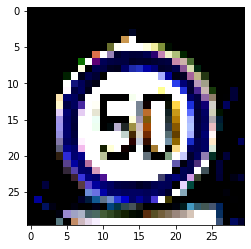

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


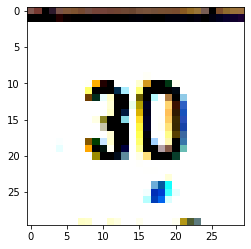

In [9]:
plt.imshow(X_train[0].view(30,30,3))
plt.show()

plt.imshow(X_train[1].view(30,30,3))
plt.show()

In [10]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

3576 3576
894 894


In [11]:
#create training and testing sets
train_data = [(X_train[i], y_train[i]) for i in range(len(X_train))]
test_data = [(X_test[i], y_test[i]) for i in range(len(X_test))]

print(len(train_data))
    
trainset = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
testset = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

3576


Logistic Regression

In [53]:
class LogReg(torch.nn.Module):
    
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(2700, 1)
        
    def forward(self, x):
        y_pred = F.sigmoid(self.linear(x))
        return y_pred

In [58]:
model = LogReg()

criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
EPOCHS = 1000
training_loss = []
train_acc = []
test_acc = []

In [59]:
#Begin training

for epoch in range(EPOCHS):
    
    y_pred = model(X_train)
    
    loss = criterion(y_pred, y_train)
    training_loss.append(loss)
 
        
    #gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100== 0:
        correct = 0
        total = 0

        for data in trainset:
            X,y = data
            output = model(X)
            for idx, i in enumerate(output):
                if torch.round(i) == y[idx]:
                    correct+=1
                total+=1
            train_acc.append(correct/total)

        correct = 0
        total = 0

        for data in testset:
            X,y = data
            output = model(X)
            for idx, i in enumerate(output):
                if torch.round(i) == y[idx]:
                    correct+=1
                total+=1
            test_acc.append(correct/total)
       
    
        print(epoch, loss.item(), "Accuracy:", correct/total)
        
        

0 0.685893177986145 Accuracy: 0.6152125279642058
100 0.32600727677345276 Accuracy: 0.9071588366890381
200 0.2581084668636322 Accuracy: 0.9295302013422819
300 0.22341379523277283 Accuracy: 0.9407158836689038
400 0.2012125700712204 Accuracy: 0.9407158836689038
500 0.18531814217567444 Accuracy: 0.9463087248322147
600 0.17314347624778748 Accuracy: 0.9496644295302014
700 0.16338618099689484 Accuracy: 0.9541387024608501
800 0.15531009435653687 Accuracy: 0.9574944071588367
900 0.1484616994857788 Accuracy: 0.9574944071588367


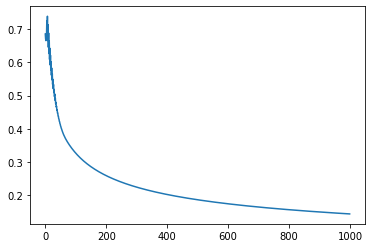

In [60]:
plt.plot(training_loss)

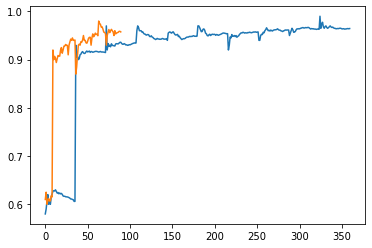

In [61]:
plt.plot(train_acc)
plt.plot(test_acc)

In [62]:
#see training accuracy
correct = 0
total = 0

for data in trainset:
    X,y = data
    output = model(X)
    for idx, i in enumerate(output):
        if torch.round(i) == y[idx]:
            correct+=1
        total+=1

print('Train Accuracy', round(correct/total, 3))



Train Accuracy 0.966
